# PPCA in PyStan

In this notebook, we try to perform a PPCA in Pystan.

In [16]:
from mpl_toolkits.mplot3d import Axes3D
import pystan
import numpy as np
import seaborn as sns
sns.set()

Here, the model is defined in Stan. It is based on the original model as defined by Pierson (2015). Note that we make use of the logit-transformed bernoulli parametrization as it is numerically more stable on the given scale.

In [17]:
zifa = """

data{
    int<lower=0> N; // number  of  datapoints
    int<lower=0> D; // number  of  dimensions  in  observed  dataset
    int<lower=0> M; // number  of  dimensions  in  latent  dataset
    matrix[N,D] y; // zero inflated observations
}

parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] A;  // factor loadings
    vector<lower=0>[D] sigmas;   //  standard  deviations
    real<lower=0, upper=0.5> lambda; // zero-inflation
    vector[D] mu;   //  added means
    matrix[N,D] x; // non-inflated observations
}

transformed parameters{
    // means and covariacne matrix of z
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model{
    
    for (n in 1:N){
        target+=-0.5*(z[:,n]'*z[:,n]);
        for (d in 1:D){
            if (y[n,d]==0){
            
                // exact formula (Works only for Bernoulli process for some reason)
                //target+=-square(x[n,d]-row(A,d)*col(z,n)+mu[d])/(2*square(sigmas[d])) - 0.5*log(square(sigmas[d])) - lambda*square(x[n,d]);
                target+= -lambda*square(x[n,d]);
                
                // PyStan implementation (Works only for Gaussian distribution for some reason)
                target+=normal_lpdf(x[n,d]|row(A,d)*col(z,n)+mu[d], sigmas[d]);
                //target+=bernoulli_logit_lpmf(1|-square(x[n,d])*lambda);
                
            } else {
                
                // exact formula (Works only for Bernoulli process for some reason)
                //target+=-square(y[n,d]-row(A,d)*col(z,n)+mu[d])/(2*square(sigmas[d])) - 0.5*log(square(sigmas[d])) + log(1-exp(-lambda*square(y[n,d])));
                //target+=-square(x[n,d]-row(A,d)*col(z,n)+mu[d])/(2*square(sigmas[d])) - 0.5*log(square(sigmas[d])) + log(1-exp(-lambda*square(y[n,d])));
                target+=log(1-exp(-lambda*square(y[n,d])));
                
                // PyStan implementation (Works only for Gaussian distribution for some reason)
                target+=normal_lpdf(x[n,d]|row(A,d)*col(z,n)+mu[d], sigmas[d]);
                target+=normal_lpdf(y[n,d]|row(A,d)*col(z,n)+mu[d], sigmas[d]);
                //target+=bernoulli_logit_lpmf(1|log(1-exp(-lambda*square(y[n,d]))));
            }
        }
    }
}

"""
zifa_model = pystan.StanModel(model_code=zifa)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_e5d722c6a5ce8165f995287276d3253d NOW.


Note the log-probability in the 'model'-section of the code. We take $p(\sigma^2)$, $p(z)$ and $p(x|z)$ into account first. Then we take $p(h=1|x)$ or $p(h=0|x)$, depending on whether the datapoint is zero or non-zero. The reasoning behind this is given in the supplementary material of E. Pierson (2015). Unlike the original article, we also take $p(y|z,h)$ (which is $1$ is $h=1$) into account, to get a more accurate estimate of $z$, $A$ and $W$. We end up with a complete likelihood of $$\prod^N_{i=1}p(z_i)\Big(\prod_{j:y_{i,j}=0}p(x_{i,j}|z_i)p(h_{i,j}=1|x_{i,j})\prod_{j:y_{i,j}\neq}p(x_{i,j}|z_i)p(h_{i,j}=0|x_{i,j})\Big)$$

Note that our model does not take the prior distributions of $\mu$, $\sigma^2$ and $W$ into account, like the original model. This is because these parameters were chosen manually or came from uniform distributions in the original paper, leaving them with flat priors.

We specify our parameters as done in the original paper and generate some data.

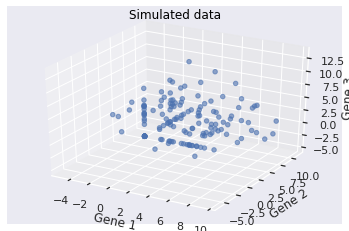

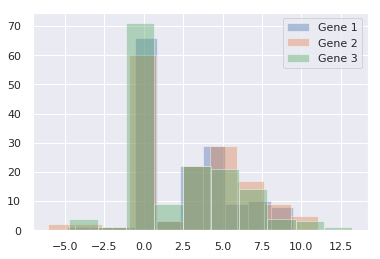

In [18]:
N=150
D=3
M=2

z = np.random.multivariate_normal(np.zeros(M),cov=np.eye(M), size=(N)).T
mu = np.random.uniform(2.7,3.3,size=(D,1))
lamda = 0.1
sigma_A = 0.3
A = np.zeros((D,M))

for i in range(D):
    for j in range(M):
        if i==j:
            A[i,j] = np.random.uniform(.9*sigma_A,1.1*sigma_A)
        else:
            A[i,j] = np.random.uniform(-.5,.5)

            
W = np.random.uniform(2.7,3.3,size=(D,1))
x = np.random.normal(np.matmul(A,z)+mu,W).T
h = np.random.binomial(n=1, p=1-np.exp(-(x**2)*lamda))
y = x*h

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.6)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y[:,0], alpha=0.4, label='Gene 1')
plt.hist(y[:,1], alpha=0.4, label='Gene 2')
plt.hist(y[:,2], alpha=0.4, label='Gene 3')
plt.legend()
plt.show()

Note that $x$ and $y_{y\not=0}$ are assumed to come from the same distribution in the (original) model and this assumption is used to estimate $x$, which is again used to estimate $\lambda$, but this assumption does not hold! since the lowest values of $x$ were put to $0$, $y_{y\not=0}$ has a higher mean and lower standard deviation! This is hwy the model tends to be inaccurate when estimating $x$, and as a result, $\lambda$ is estimated too low. The effect is especially strong when $y$ has positive values, as is the case in gene-expression data.

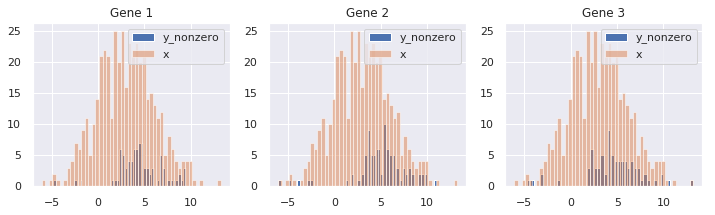

mean of x:  [2.73390053 3.33024527 2.87835607] , std. dev. of x:  [2.93645719 3.26322645 2.98454943]
mean of non-zero y:  [4.555217700549643, 4.9838670373016996, 4.571477799726187] , std. dev. of non-zero y:  [2.426111843027863, 2.9479867487135, 2.989639124028502]


In [19]:
y_nz_mean, y_nz_std = [], []
sns.set()
fig = plt.figure(figsize=(4*D,3))
for i in range(D):
    ax = fig.add_subplot(1,3,i+1)
    y_tmp = y[:,i][y[:,i]!=0]
    ax.hist(y_tmp, bins=int(N/3), alpha=1, label='y_nonzero')
    ax.hist(np.concatenate(x), bins=int(N/3), alpha=0.5, label='x')
    ax.legend()
    ax.set_title('Gene '+str(i+1))
    y_nz_mean.append(np.mean(y_tmp))
    y_nz_std.append(np.std(y_tmp))
plt.show()
print('mean of x: ', np.mean(x, axis=0), ', std. dev. of x: ', np.std(x, axis=0))

print('mean of non-zero y: ', y_nz_mean, ', std. dev. of non-zero y: ', y_nz_std)

And then we can optimize our parameters and latent dataset.

In [20]:
zifa_dat = {'N': N, 'D':D, 'M':M, 'y':y}
fit = zifa_model.sampling(data=zifa_dat, chains=1, iter=200)
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

In [21]:
z_sim = fit_ext['z'][best_ind]
mu_sim = np.mean(fit_ext['mu'],axis=0)
W_sim = np.mean(fit_ext['sigmas'],axis=0)
lambda_sim = np.mean(fit_ext['lambda'],axis=0)
A_sim = np.mean(fit_ext['A'],axis=0)

x_sim = fit_ext['x'][best_ind]
# x_sim = np.random.normal(np.matmul(z_sim.T,A_sim.T)+mu_sim,sigma_sim)    # or x can be recreated from z, W and sigma
h_sim = np.random.binomial(n=1, p=1-np.exp(-(x_sim**2)*lambda_sim))
y_sim = x_sim*h_sim

print('real mu: ', mu.T)
print('simulated mu: ', mu_sim)
print()
print('real W: ', W[:,0])
print('simulated W: ', W_sim)
print()
print('real lambda: ', lamda)
print('simulated lambda: ', lambda_sim)
print()
print('real AA^T:\n', np.matmul(A,A.T))
print('simulated AA^T:\n', np.matmul(A_sim,A_sim.T))
print()

real mu:  [[2.78197565 3.25309181 3.24190836]]
simulated mu:  [3.17489782 3.41261742 2.90432289]

real W:  [3.06117586 3.29055243 3.19815848]
simulated W:  [2.34602964 2.95226694 2.69974744]

real lambda:  0.1
simulated lambda:  0.09212989309625344

real AA^T:
 [[ 0.12482792  0.04851353 -0.06916857]
 [ 0.04851353  0.09830459  0.07508512]
 [-0.06916857  0.07508512  0.16919246]]
simulated AA^T:
 [[0.54042303 0.2265692  0.45925393]
 [0.2265692  0.14616329 0.12727774]
 [0.45925393 0.12727774 0.47350149]]



In [22]:
print('Real mean of x: ',np.mean(x, axis=0))
print('Simulated mean of x: ',np.mean(x_sim, axis=0))
print('mean of non-zero y: ', y_nz_mean)
print()
print('Real cov. matrix of x:\n',np.cov(x.T))
print('Simulated cov. matrix of x:\n',np.cov(x_sim.T))
print()
print('Real mean of z: ',np.mean(z, axis=1))
print('Simulated mean of z: ',np.mean(z_sim, axis=1))
print()
print('Real cov. matrix of z:\n',np.cov(z))
print('Simulated cov. matrix of z:\n',np.cov(z_sim))

Real mean of x:  [2.73390053 3.33024527 2.87835607]
Simulated mean of x:  [2.49898746 2.92110128 2.30087685]
mean of non-zero y:  [4.555217700549643, 4.9838670373016996, 4.571477799726187]

Real cov. matrix of x:
 [[ 8.68065185  0.60336967  0.17996645]
 [ 0.60336967 10.7201143  -1.34360682]
 [ 0.17996645 -1.34360682  8.96731741]]
Simulated cov. matrix of x:
 [[ 7.50804841  1.80810624  1.49441506]
 [ 1.80810624  8.23992558 -2.53978588]
 [ 1.49441506 -2.53978588  8.13124333]]

Real mean of z:  [-0.00590953 -0.22202102]
Simulated mean of z:  [ 0.22261574 -0.10634596]

Real cov. matrix of z:
 [[ 0.98621539 -0.21152835]
 [-0.21152835  1.1348756 ]]
Simulated cov. matrix of z:
 [[ 1.13901381 -0.01800012]
 [-0.01800012  0.98567638]]


The result is plotted below. The result looks a lot like the original. However, $\bar{A}$ is still not a correct rotation of $A$ and $\bar{x}$ has a different mean (although $\mu$ tends to be guessed correctly!) and covariance matrix, but the differences between $\bar{x}$ and $x$ are relatively small.

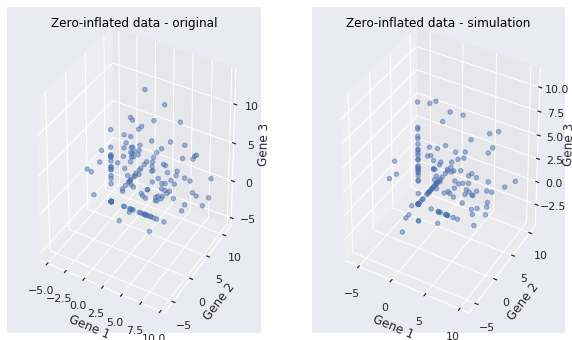

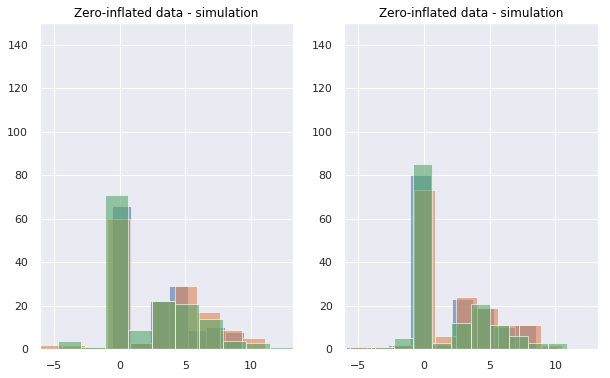

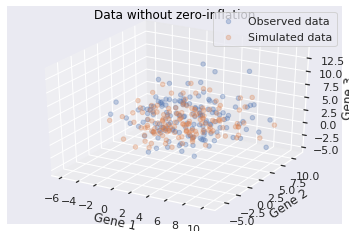

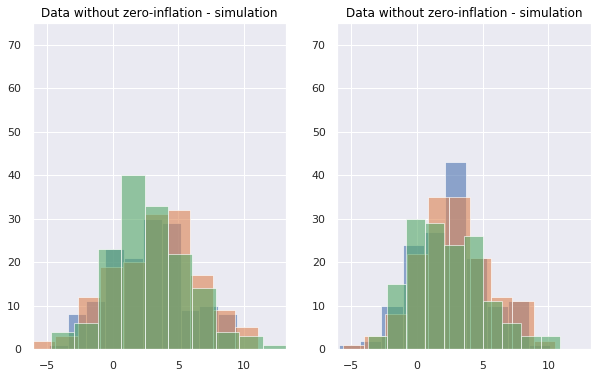

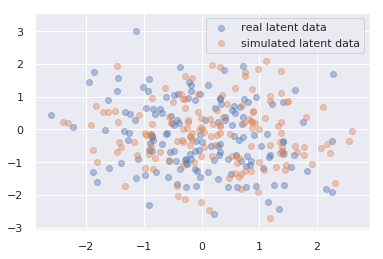

In [23]:
sns.set()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.5)
title = ax.set_title("Zero-inflated data - original")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(y_sim[:,0],y_sim[:,1],y_sim[:,2], label='Simulated data', alpha=0.5)
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.hist(y[:,0], alpha=0.6)
ax.hist(y[:,1], alpha=0.6)
ax.hist(y[:,2], alpha=0.6)
ax.set_xlim(min(np.min(y),np.min(y_sim)),max(np.max(y),np.max(y_sim)))
ax.set_ylim((0,N))
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
ax.hist(y_sim[:,0], alpha=0.6)
ax.hist(y_sim[:,1], alpha=0.6)
ax.hist(y_sim[:,2], alpha=0.6)
ax.set_ylim((0,N))
ax.set_xlim(min(np.min(y),np.min(y_sim)),max(np.max(y),np.max(y_sim)))
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim[:,0],x_sim[:,1],x_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Data without zero-inflation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.hist(x[:,0], alpha=0.6)
ax.hist(x[:,1], alpha=0.6)
ax.hist(x[:,2], alpha=0.6)
ax.set_xlim(min(np.min(x),np.min(x_sim)),max(np.max(x),np.max(x_sim)))
ax.set_ylim((0,N/2))
title = ax.set_title("Data without zero-inflation - simulation")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
ax.hist(x_sim[:,0], alpha=0.6)
ax.hist(x_sim[:,1], alpha=0.6)
ax.hist(x_sim[:,2], alpha=0.6)
ax.set_xlim(min(np.min(x),np.min(x_sim)),max(np.max(x),np.max(x_sim)))
ax.set_ylim((0,N/2))
title = ax.set_title("Data without zero-inflation - simulation")
plt.setp(title, color='black') 
plt.show()

plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_sim[0,:], z_sim[1,:], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()


## ZI-PPCA

In [10]:
zippca = """

data{
    int<lower=0> N; // number  of  datapoints
    int<lower=0> D; // number  of  dimensions  in  observed  dataset
    int<lower=0> M; // number  of  dimensions  in  latent  dataset
    matrix[N,D] y; // zero inflated observations
}

parameters{
    matrix[M,N] z;  // latent data
    matrix[D,M] A;  // factor loadings
    real<lower=0> sigma;   //  standard  deviations
    real<lower=0, upper=0.5> lambda; // zero-inflation
    vector[D] mu;   //  added means
    matrix[N,D] x; // non-inflated observations
}

transformed parameters{
    // means and covariacne matrix of z
    vector[M] mean_z;
    matrix[M,M] cov_z;
    
    for (m in 1:M){
        mean_z[m] = 0.0;
        for (n in 1:M){
            if (m==n){
                cov_z[m,n]=1.0;
            } else{
                cov_z[m,n]=0.0;
            }
        }
    }
}

model{
    
    for (n in 1:N){
        target+=multi_normal_lpdf(z[:,n]|mean_z,cov_z);
        for (d in 1:D){
            if (y[n,d]==0){
                // exact formula (Works only for Bernoulli process for some reason)
                //target+=-square(x[n,d]-row(A,d)*col(z,n)+mu[d])/(2*square(sigma)) - 0.5*log(square(sigma)) - lambda*square(x[n,d]);
                target+= -lambda*square(x[n,d]);
                
                // PyStan implementation (Works only for Gaussian distribution for some reason)
                target+=normal_lpdf(x[n,d]|row(A,d)*col(z,n)+mu[d], sigma);
                //target+=bernoulli_logit_lpmf(1|-square(x[n,d])*lambda);
                
            } else {
                
                // exact formula (Works only for Bernoulli process for some reason)
                //target+=-square(y[n,d]-row(A,d)*col(z,n)+mu[d])/(2*square(sigma)) - 0.5*log(square(sigma)) + log(1-exp(-lambda*square(y[n,d])));
                //target+=-square(x[n,d]-row(A,d)*col(z,n)+mu[d])/(2*square(sigma)) - 0.5*log(square(sigma)) + log(1-exp(-lambda*square(y[n,d])));
                target+=log(1-exp(-lambda*square(y[n,d])));
                
                // PyStan implementation (Works only for Gaussian distribution for some reason)
                target+=normal_lpdf(x[n,d]|row(A,d)*col(z,n)+mu[d], sigma);
                target+=normal_lpdf(y[n,d]|row(A,d)*col(z,n)+mu[d], sigma);
                //target+=bernoulli_logit_lpmf(1|log(1-exp(-lambda*square(y[n,d]))));
            }
        }
    }
}
"""
zippca_model = pystan.StanModel(model_code=zippca)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_3a77dbf451290b768cf383b9ee93d8f2 NOW.


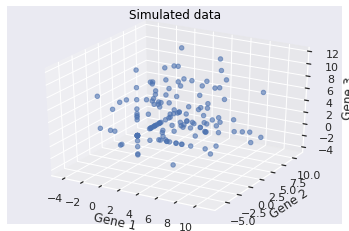

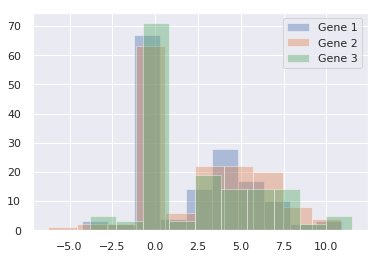

In [11]:
N=150
D=3
M=2

z = np.random.normal(0,1, size=(M,N))
mu = np.random.uniform(2.7,3.3,size=(D,1))
lamda = 0.1
sigma_A = 0.3
A = np.zeros((D,M))

for i in range(D):
    for j in range(M):
        if i==j:
            A[i,j] = np.random.uniform(.9*sigma_A,1.1*sigma_A)
        else:
            A[i,j] = np.random.uniform(-.5,.5)

            
sigma = np.random.uniform(2.7,3.3)
x = np.random.normal(np.matmul(A,z)+mu,sigma).T
h = np.random.binomial(n=1, p=1-np.exp(-(x**2)*lamda))
y = x*h

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.6)
title = ax.set_title("Simulated data")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

plt.hist(y[:,0], alpha=0.4, label='Gene 1')
plt.hist(y[:,1], alpha=0.4, label='Gene 2')
plt.hist(y[:,2], alpha=0.4, label='Gene 3')
plt.legend()
plt.show()

And then we can optimize our parameters and latent dataset.

In [12]:
zippca_dat = {'N': N, 'D':D, 'M':M, 'y':y}
fit = zippca_model.sampling(data=zippca_dat, chains=1, iter=200, verbose=True)
fit_ext = fit.extract()
best_ind = np.where(fit_ext['lp__']==max(fit_ext['lp__']))[0][0]

In [13]:
z_sim = fit_ext['z'][best_ind]
mu_sim = np.mean(fit_ext['mu'],axis=0)
sigma_sim = np.mean(fit_ext['sigma'],axis=0)
lambda_sim = np.mean(fit_ext['lambda'],axis=0)
A_sim = np.mean(fit_ext['A'],axis=0)


x_sim = fit_ext['x'][best_ind]
# x_sim = np.random.normal(np.matmul(z_sim.T,A_sim.T)+mu_sim,sigma_sim)    # or x can be recreated from z, W and sigma
h_sim = np.random.binomial(n=1, p=1-np.exp(-(x_sim**2)*lambda_sim))
y_sim = x_sim*h_sim

print('real mu: ', mu.T)
print('simulated mu: ', mu_sim)
print()
print('real sigma: ', sigma)
print('simulated sigma: ', sigma_sim)
print()
print('real lambda: ', lamda)
print('simulated lambda: ', lambda_sim)
print()
print('real AA^T:\n', np.matmul(A,A.T))
print('simulated AA^T:\n', np.matmul(A_sim,A_sim.T))
print()

real mu:  [[3.00832893 3.17930881 3.10119581]]
simulated mu:  [2.70040626 3.1317825  2.8964336 ]

real sigma:  2.92481640786397
simulated sigma:  2.7712124012052586

real lambda:  0.1
simulated lambda:  0.1040254250434641

real AA^T:
 [[ 0.24137014 -0.03497856  0.15875641]
 [-0.03497856  0.14013183  0.08560698]
 [ 0.15875641  0.08560698  0.19176248]]
simulated AA^T:
 [[0.24340816 0.37725694 0.29122238]
 [0.37725694 0.58483012 0.45447733]
 [0.29122238 0.45447733 0.42806646]]



In [14]:
print('Real mean of x: ',np.mean(x, axis=0))
print('Simulated mean of x: ',np.mean(x_sim, axis=0))
print()
print('Real cov. matrix of x:\n',np.cov(x.T))
print('Simulated cov. matrix of x:\n',np.cov(x_sim.T))
print()
print('Real mean of z: ',np.mean(z, axis=1))
print('Simulated mean of z: ',np.mean(z_sim, axis=1))
print()
print('Real cov. matrix of z:\n',np.cov(z))
print('Simulated cov. matrix of z:\n',np.cov(z_sim))

Real mean of x:  [2.7231784  3.18897353 2.87181604]
Simulated mean of x:  [1.70752263 2.53570608 2.32288146]

Real cov. matrix of x:
 [[ 8.15392169  0.52909767  0.64976727]
 [ 0.52909767  9.32194661  0.62645239]
 [ 0.64976727  0.62645239 11.39977317]]
Simulated cov. matrix of x:
 [[6.1931045  2.07847005 0.7838289 ]
 [2.07847005 7.18849227 1.07290635]
 [0.7838289  1.07290635 7.41815256]]

Real mean of z:  [ 0.06965427 -0.26165041]
Simulated mean of z:  [ 0.17363499 -0.05532201]

Real cov. matrix of z:
 [[ 1.14424061 -0.07208596]
 [-0.07208596  0.87182307]]
Simulated cov. matrix of z:
 [[0.94487546 0.00972105]
 [0.00972105 1.03472554]]


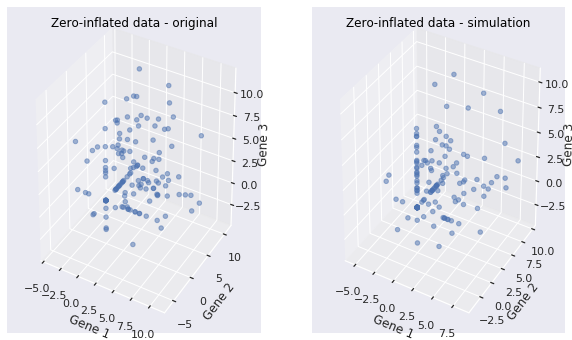

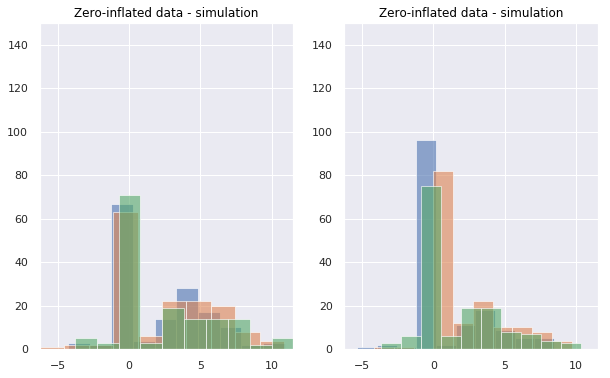

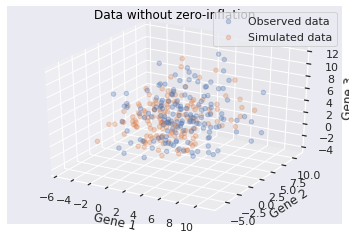

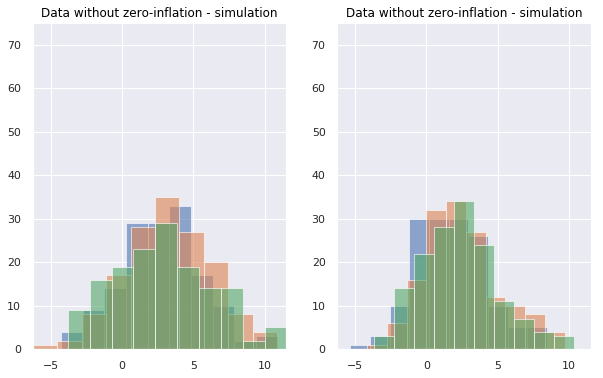

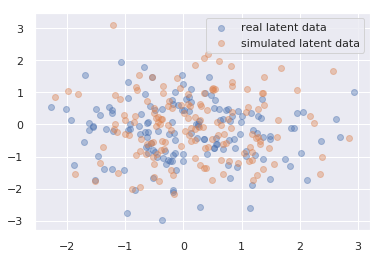

In [15]:
sns.set()
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1, projection='3d')
ax.scatter(y[:,0],y[:,1],y[:,2], label='Observed data', alpha=0.5)
title = ax.set_title("Zero-inflated data - original")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
ax = fig.add_subplot(1,2,2, projection='3d')
ax.scatter(y_sim[:,0],y_sim[:,1],y_sim[:,2], label='Simulated data', alpha=0.5)
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.hist(y[:,0], alpha=0.6)
ax.hist(y[:,1], alpha=0.6)
ax.hist(y[:,2], alpha=0.6)
ax.set_xlim(min(np.min(y),np.min(y_sim)),max(np.max(y),np.max(y_sim)))
ax.set_ylim((0,N))
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
ax.hist(y_sim[:,0], alpha=0.6)
ax.hist(y_sim[:,1], alpha=0.6)
ax.hist(y_sim[:,2], alpha=0.6)
ax.set_ylim((0,N))
ax.set_xlim(min(np.min(y),np.min(y_sim)),max(np.max(y),np.max(y_sim)))
title = ax.set_title("Zero-inflated data - simulation")
plt.setp(title, color='black') 
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0],x[:,1],x[:,2], label='Observed data', alpha=0.3)
ax.scatter(x_sim[:,0],x_sim[:,1],x_sim[:,2], label='Simulated data', alpha=0.3)
title = ax.set_title("Data without zero-inflation")
plt.setp(title, color='black') 
ax.set_xlabel('Gene 1')
ax.set_ylabel('Gene 2')
ax.set_zlabel('Gene 3')
plt.legend()
plt.show()

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,2,1)
ax.hist(x[:,0], alpha=0.6)
ax.hist(x[:,1], alpha=0.6)
ax.hist(x[:,2], alpha=0.6)
ax.set_xlim(min(np.min(x),np.min(x_sim)),max(np.max(x),np.max(x_sim)))
ax.set_ylim((0,N/2))
title = ax.set_title("Data without zero-inflation - simulation")
plt.setp(title, color='black') 
ax = fig.add_subplot(1,2,2)
ax.hist(x_sim[:,0], alpha=0.6)
ax.hist(x_sim[:,1], alpha=0.6)
ax.hist(x_sim[:,2], alpha=0.6)
ax.set_xlim(min(np.min(x),np.min(x_sim)),max(np.max(x),np.max(x_sim)))
ax.set_ylim((0,N/2))
title = ax.set_title("Data without zero-inflation - simulation")
plt.setp(title, color='black') 
plt.show()

plt.scatter(z[0,:], z[1,:], label='real latent data', alpha=0.4)
plt.scatter(z_sim[0,:], z_sim[1,:], label='simulated latent data', alpha=0.4)
plt.legend()
plt.show()
